<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 304, '日付': '2021-06-13T08:00:00.000Z'},
 {'小計': 209, '日付': '2021-06-14T08:00:00.000Z'},
 {'小計': 337, '日付': '2021-06-15T08:00:00.000Z'},
 {'小計': 501, '日付': '2021-06-16T08:00:00.000Z'},
 {'小計': 452, '日付': '2021-06-17T08:00:00.000Z'},
 {'小計': 453, '日付': '2021-06-18T08:00:00.000Z'},
 {'小計': 388, '日付': '2021-06-19T08:00:00.000Z'},
 {'小計': 376, '日付': '2021-06-20T08:00:00.000Z'},
 {'小計': 236, '日付': '2021-06-21T08:00:00.000Z'},
 {'小計': 435, '日付': '2021-06-22T08:00:00.000Z'},
 {'小計': 619, '日付': '2021-06-23T08:00:00.000Z'},
 {'小計': 570, '日付': '2021-06-24T08:00:00.000Z'},
 {'小計': 562, '日付': '2021-06-25T08:00:00.000Z'},
 {'小計': 534, '日付': '2021-06-26T08:00:00.000Z'},
 {'小計': 386, '日付': '2021-06-27T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-06-23 17:00:00+09:00,375,0,619,2021-06-23 17:00:00+09:00
2021-06-24 17:00:00+09:00,344,0,570,2021-06-24 17:00:00+09:00
2021-06-25 17:00:00+09:00,0,0,562,2021-06-25 17:00:00+09:00
2021-06-26 17:00:00+09:00,0,0,534,2021-06-26 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-06-23 17:00:00+09:00,375,0,619,2021-06-23 17:00:00+09:00,347.000000,2429.0,0.0,0.0,422.714286,2959.0
2021-06-24 17:00:00+09:00,344,0,570,2021-06-24 17:00:00+09:00,345.285714,2417.0,0.0,0.0,439.571429,3077.0
2021-06-25 17:00:00+09:00,0,0,562,2021-06-25 17:00:00+09:00,300.428571,2103.0,0.0,0.0,455.142857,3186.0
2021-06-26 17:00:00+09:00,0,0,534,2021-06-26 17:00:00+09:00,250.857143,1756.0,0.0,0.0,476.000000,3332.0
2021-06-27 17:00:00+09:00,0,0,386,2021-06-27 17:00:00+09:00,203.142857,1422.0,0.0,0.0,477.428571,3342.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-06-13 17:00:00+09:00,283,0,304,2021-06-13 17:00:00+09:00,326.857143,2288.0,0.0,0.0,384.142857,2689.0,'21w23,Sun
2021-06-14 17:00:00+09:00,354,0,209,2021-06-14 17:00:00+09:00,321.571429,2251.0,0.0,0.0,380.428571,2663.0,'21w24,Mon
2021-06-15 17:00:00+09:00,337,0,337,2021-06-15 17:00:00+09:00,327.857143,2295.0,0.0,0.0,375.857143,2631.0,'21w24,Tue
2021-06-16 17:00:00+09:00,319,0,501,2021-06-16 17:00:00+09:00,325.428571,2278.0,0.0,0.0,384.571429,2692.0,'21w24,Wed
2021-06-17 17:00:00+09:00,356,0,452,2021-06-17 17:00:00+09:00,330.285714,2312.0,0.0,0.0,386.428571,2705.0,'21w24,Thu
2021-06-18 17:00:00+09:00,314,0,453,2021-06-18 17:00:00+09:00,330.428571,2313.0,0.0,0.0,389.000000,2723.0,'21w24,Fri
2021-06-19 17:00:00+09:00,347,0,388,2021-06-19 17:00:00+09:00,330.000000,2310.0,0.0,0.0,377.714286,2644.0,'21w24,Sat
2021-06-20 17:00:00+09:00,334,0,376,2021-06-20 17:00:00+09:00,337.285714,2361.0,0.0,0.0,388.000000,2716.0,'21w24,Sun
2021-06-21 17:00:00+09:00,373,0,236,2021-06-21 17:00:00+09:00,340.000000,2380.0,0.0,0.0,391.857143,2743.0,'21w25,Mon
2021-06-22 17:00:00+09:00,330,0,435,2021-06-22 17:00:00+09:00,339.000000,2373.0,0.0,0.0,405.857143,2841.0,'21w25,Tue


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-06-06 17:00:00+09:00,426.428571,2985
2021-06-13 17:00:00+09:00,384.142857,2689
2021-06-20 17:00:00+09:00,388.000000,2716
2021-06-27 17:00:00+09:00,477.428571,3342
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-06-13 17:00:00+09:00,283,0,304,2021-06-13 17:00:00+09:00,326.857143,2288.0,0.0,0.0,384.142857,2689.0,'21w23,Sun,384.142857,2689.0
2021-06-14 17:00:00+09:00,354,0,209,2021-06-14 17:00:00+09:00,321.571429,2251.0,0.0,0.0,380.428571,2663.0,'21w24,Mon,NaN,NaN
2021-06-15 17:00:00+09:00,337,0,337,2021-06-15 17:00:00+09:00,327.857143,2295.0,0.0,0.0,375.857143,2631.0,'21w24,Tue,NaN,NaN
2021-06-16 17:00:00+09:00,319,0,501,2021-06-16 17:00:00+09:00,325.428571,2278.0,0.0,0.0,384.571429,2692.0,'21w24,Wed,NaN,NaN
2021-06-17 17:00:00+09:00,356,0,452,2021-06-17 17:00:00+09:00,330.285714,2312.0,0.0,0.0,386.428571,2705.0,'21w24,Thu,NaN,NaN
2021-06-18 17:00:00+09:00,314,0,453,2021-06-18 17:00:00+09:00,330.428571,2313.0,0.0,0.0,389.000000,2723.0,'21w24,Fri,NaN,NaN
2021-06-19 17:00:00+09:00,347,0,388,2021-06-19 17:00:00+09:00,330.000000,2310.0,0.0,0.0,377.714286,2644.0,'21w24,Sat,NaN,NaN
2021-06-20 17:00:00+09:00,334,0,376,2021-06-20 17:00:00+09:00,337.285714,2361.0,0.0,0.0,388.000000,2716.0,'21w24,Sun,388.000000,2716.0
2021-06-21 17:00:00+09:00,373,0,236,2021-06-21 17:00:00+09:00,340.000000,2380.0,0.0,0.0,391.857143,2743.0,'21w25,Mon,NaN,NaN
2021-06-22 17:00:00+09:00,330,0,435,2021-06-22 17:00:00+09:00,339.000000,2373.0,0.0,0.0,405.857143,2841.0,'21w25,Tue,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

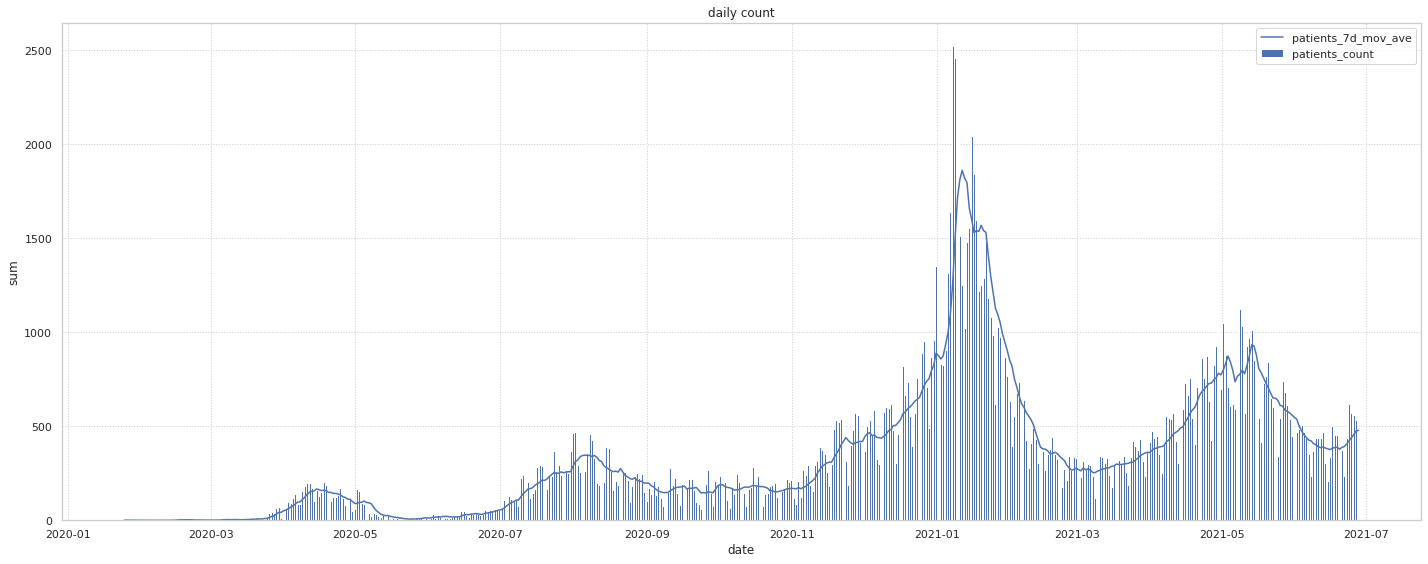

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
506,1.623571e+09,2021,6,13,0,0,0,1,0,0,0,506,0,432,283,326.857143,2288.0,0,0.0,0.0,304,384.142857,2689.0
507,1.623658e+09,2021,6,14,0,1,0,0,0,0,0,507,0,433,354,321.571429,2251.0,0,0.0,0.0,209,380.428571,2663.0
508,1.623744e+09,2021,6,15,0,0,0,0,0,1,0,508,0,434,337,327.857143,2295.0,0,0.0,0.0,337,375.857143,2631.0
509,1.623830e+09,2021,6,16,0,0,0,0,0,0,1,509,0,435,319,325.428571,2278.0,0,0.0,0.0,501,384.571429,2692.0
510,1.623917e+09,2021,6,17,0,0,0,0,1,0,0,510,0,436,356,330.285714,2312.0,0,0.0,0.0,452,386.428571,2705.0
511,1.624003e+09,2021,6,18,1,0,0,0,0,0,0,511,0,437,314,330.428571,2313.0,0,0.0,0.0,453,389.000000,2723.0
512,1.624090e+09,2021,6,19,0,0,1,0,0,0,0,512,0,438,347,330.000000,2310.0,0,0.0,0.0,388,377.714286,2644.0
513,1.624176e+09,2021,6,20,0,0,0,1,0,0,0,513,0,439,334,337.285714,2361.0,0,0.0,0.0,376,388.000000,2716.0
514,1.624262e+09,2021,6,21,0,1,0,0,0,0,0,514,0,440,373,340.000000,2380.0,0,0.0,0.0,236,391.857143,2743.0
515,1.624349e+09,2021,6,22,0,0,0,0,0,1,0,515,0,441,330,339.000000,2373.0,0,0.0,0.0,435,405.857143,2841.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            521 non-null    float64
 1   year                 521 non-null    int64  
 2   month                521 non-null    int64  
 3   day                  521 non-null    int64  
 4   Fri                  521 non-null    uint8  
 5   Mon                  521 non-null    uint8  
 6   Sat                  521 non-null    uint8  
 7   Sun                  521 non-null    uint8  
 8   Thu                  521 non-null    uint8  
 9   Tue                  521 non-null    uint8  
 10  Wed                  521 non-null    uint8  
 11  passed               521 non-null    int64  
 12  emergency            521 non-null    int64  
 13  em_passed            521 non-null    int64  
 14  contacts_count       521 non-null    int64  
 15  contacts_7d_mov_ave  521 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,5.210000e+02,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000
mean,1.602317e+09,2020.341651,5.715931,15.792706,0.143954,0.142035,0.143954,0.143954,0.142035,0.142035,0.142035,260.000000,0.094050,191.326296,653.848369,653.270313,4572.884837,707.330134,707.330134,4951.310940,330.953935,328.047244,2296.299424
std,1.300700e+07,0.474719,3.249840,8.810790,0.351380,0.349421,0.351380,0.351380,0.349421,0.349421,0.349421,150.544013,0.292179,142.775473,434.150641,420.666253,2944.675156,864.825004,778.148934,5447.042539,365.193176,344.816408,2413.744625
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.591085e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,130.000000,0.000000,56.000000,371.000000,372.714286,2609.000000,0.000000,0.000000,0.000000,72.000000,86.571429,606.000000
50%,1.602317e+09,2020.000000,5.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,260.000000,0.000000,186.000000,519.000000,530.285714,3712.000000,156.000000,285.428571,1998.000000,234.000000,238.142857,1667.000000
75%,1.613549e+09,2021.000000,8.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,390.000000,0.000000,316.000000,766.000000,749.142857,5244.000000,1335.000000,1335.285714,9347.000000,453.000000,440.857143,3086.000000
max,1.624781e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,520.000000,1.000000,446.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.821449,0.081523,0.007428,-0.002727,-0.004058,-1.567480e-18,0.002727,0.004058,-0.001353,0.001353,1.000000e+00,-0.347053,0.995899,-0.322983,-0.304704,-0.304699,-0.548714,-0.591685,-0.591685,0.607448,0.647732,0.647746
year,8.214493e-01,1.000000,-0.499150,-0.034070,0.004337,-0.003271,4.337115e-03,0.004337,-0.003271,-0.003271,-0.003271,8.214493e-01,-0.232108,0.839245,-0.305771,-0.282628,-0.282625,-0.589758,-0.655450,-0.655450,0.590190,0.647299,0.647300
month,8.152297e-02,-0.499150,1.000000,-0.017911,-0.012959,0.000036,-7.906348e-03,-0.004538,0.011890,0.005116,0.008503,8.152297e-02,-0.119655,0.043884,0.047588,0.034343,0.034347,0.199281,0.250368,0.250368,-0.111019,-0.150889,-0.150869
day,7.427500e-03,-0.034070,-0.017911,1.000000,0.013384,-0.004785,2.824435e-03,0.012142,0.000212,-0.016029,-0.007908,7.427500e-03,-0.003618,0.008934,-0.024269,-0.019095,-0.019099,0.003757,-0.010995,-0.010995,-0.003308,0.006697,0.006683
Fri,-2.726572e-03,0.004337,-0.012959,0.013384,1.000000,-0.166850,-1.681614e-01,-0.168161,-0.166850,-0.166850,-0.166850,-2.726572e-03,-0.001007,-0.001743,-0.020997,-0.004297,-0.004296,0.031972,-0.002843,-0.002843,0.048143,-0.001614,-0.001622
Mon,-4.057953e-03,-0.003271,0.000036,-0.004785,-0.166850,1.000000,-1.668497e-01,-0.166850,-0.165548,-0.165548,-0.165548,-4.057953e-03,0.000759,-0.004207,0.043484,0.002265,0.002266,0.139225,0.002144,0.002144,-0.135929,-0.001382,-0.001380
Sat,-1.567480e-18,0.004337,-0.007906,0.002824,-0.168161,-0.166850,1.000000e+00,-0.168161,-0.166850,-0.166850,-0.166850,1.291564e-18,-0.001007,0.000710,0.040873,-0.004297,-0.004296,-0.160157,-0.002843,-0.002843,0.061286,-0.000405,-0.000411
Sun,2.726572e-03,0.004337,-0.004538,0.012142,-0.168161,-0.166850,-1.681614e-01,1.000000,-0.166850,-0.166850,-0.166850,2.726572e-03,-0.001007,0.003163,-0.027552,-0.004297,-0.004296,-0.147759,-0.002843,-0.002843,-0.039362,0.000465,0.000464
Thu,4.057953e-03,-0.003271,0.011890,0.000212,-0.166850,-0.165548,-1.668497e-01,-0.166850,1.000000,-0.165548,-0.165548,4.057953e-03,0.000759,0.003155,-0.003673,0.004226,0.004227,0.041986,0.002144,0.002144,0.082321,0.002318,0.002323
Tue,-1.352651e-03,-0.003271,0.005116,-0.016029,-0.166850,-0.165548,-1.668497e-01,-0.166850,-0.165548,1.000000,-0.165548,-1.352651e-03,0.000759,-0.001779,-0.021345,0.002882,0.002883,0.056705,0.002144,0.002144,-0.034942,-0.000391,-0.000388


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,1.624435e+09,0,0,0,0,0,0,1,516,0,442,375,0,619,422.714286,2959.0
517,1.624522e+09,0,0,0,0,1,0,0,517,0,443,344,0,570,439.571429,3077.0
518,1.624608e+09,1,0,0,0,0,0,0,518,0,444,0,0,562,455.142857,3186.0
519,1.624694e+09,0,0,1,0,0,0,0,519,0,445,0,0,534,476.000000,3332.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
516,1.624435e+09,516,0,619,422.714286,2959.0
517,1.624522e+09,517,0,570,439.571429,3077.0
518,1.624608e+09,518,0,562,455.142857,3186.0
519,1.624694e+09,519,0,534,476.000000,3332.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

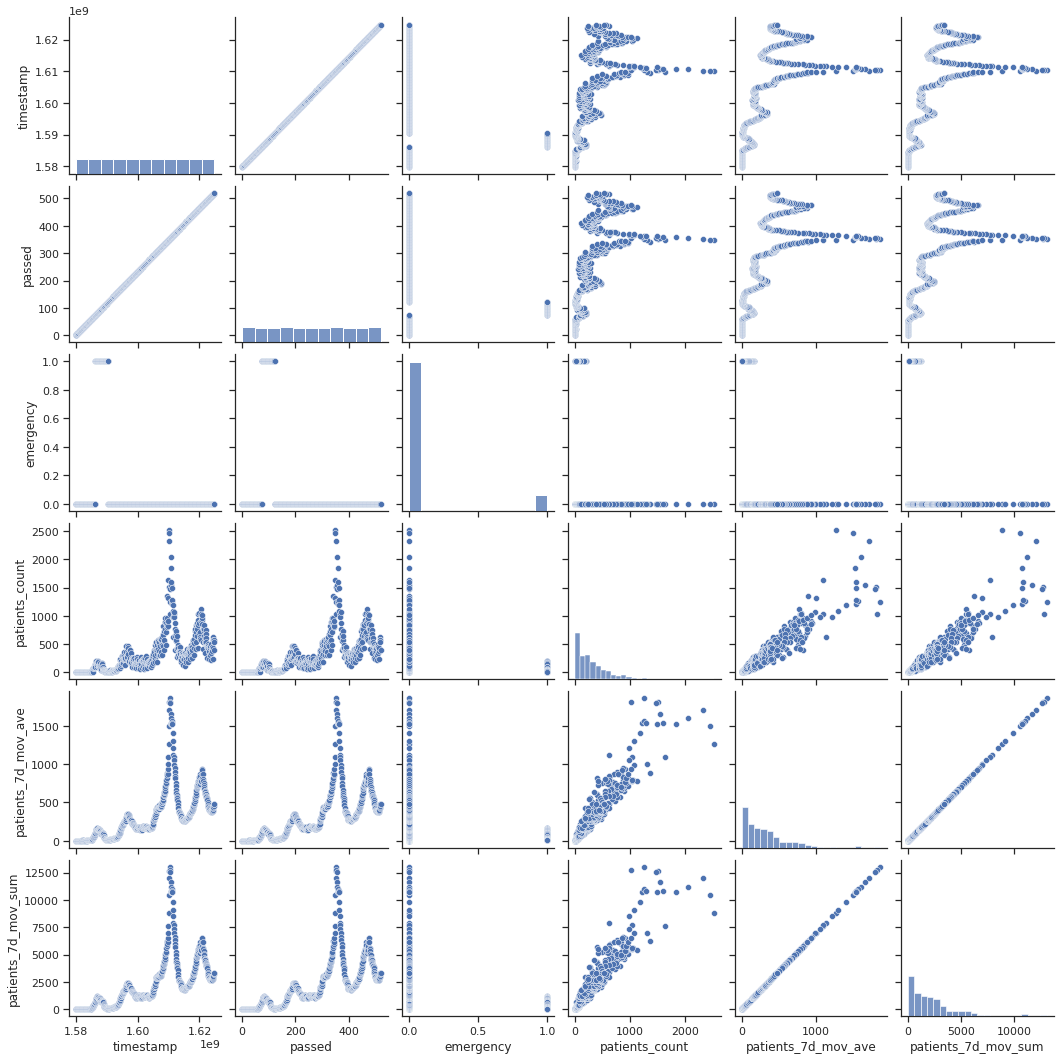

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.10
